# Results Analysis

In [1]:
from optimization.acs import ACS_VRP,ACS_TSP
from optimization.bso import BSO_VRP,BSO_TSP
from optimization.hybrid_acs_bso import ACSBSO_VRP,ACSBSO_TSP

from optimization.aco import ACO_VRP,ACO_TSP
from optimization.haco import HACO_VRP,HACO_TSP

from optimization.koneksi import ConDB

import sql_connection
import json
import time
import random
import datetime
import copy

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [2]:
def generate_data(n = 30, random_state = None):
    random.seed(random_state)
    query = """SELECT 
                    p.post_id,
                    p.post_type,
                    CASE
                        WHEN pj.pj_jam_buka = pj.pj_jam_tutup THEN "tutup"
                        ELSE "buka"
                    END AS is_operate
                FROM 
                    posts p
                LEFT JOIN
                    posts_jadwal pj
                    ON p.post_id = pj.pj_id_tempat AND pj.pj_hari = "minggu"
                """

    df_location = sql_connection.read_from_sql(query)
    
    tourid = df_location[(df_location['post_type']=="location")&
                         (df_location['is_operate'] != "tutup")]['post_id'].values.tolist()
    tourid = random.sample(tourid,n)
    idhotel = df_location[df_location['post_type']=="hotel"]['post_id'].values.tolist()
    idhotel = idhotel[random.randint(0,len(idhotel)-1)]
    
    db = ConDB()

    hotel = db.HotelbyID(idhotel)
    tur = db.WisatabyID(tourid)
    timematrix = db.TimeMatrixbyID(hotel._id,tourid)
    
    return hotel,tur,timematrix

## Analisis
scenario analisis:
1. semua degree 1, 30 pois, 3 hari wisata, all method cek fitness, travel duration, total tarif, rata-rata rating, poi included, running time
2. semua degree 1, 0, 5-10-15-20-25-30 pois, 3 hari wisata, all method, cek running time
3. degree travel duration 1 sisanya 0, 5-10-15-20-25-30 pois, 365 hari wisata, all method, cek travel duration and travel days
4. degree tarif 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek total tarif
5. degree rating 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek rata rata rating

story:
1. overview: jelasin dulu secara keseluruhan dengan scenario analisis no. 1 terus breakdown best model dengan beberapa random berbeda dan running time nya

In [3]:
def find_node(node_id,tour):
    for node in tour:
        if node._id == node_id:
            return node
    return False

def time_to_second(time):
    return (time.hour*3600)+(time.minute*60)+time.second

def diff_second_between_time(time_a,time_b):
    #input: time_a and time_b, datetime.time()
    #output: time_b - time_a, seconds (int)
    return time_to_second(time_b) - time_to_second(time_a)

def get_attribute_analysis(solution):
    days_needed = len(solution)
    poi_included = len(sum([sol["index"] for sol in solution],[]))
    avg_rating = sum(sum([sol["rating"] for sol in solution],[]))/poi_included
    total_tarif = sum(sum([sol["tarif"] for sol in solution],[]))
    total_duration = sum([diff_second_between_time(j[0],j[-1]) for j in [i['waktu'] for i in solution]])
    return days_needed,poi_included,avg_rating,total_tarif,total_duration

def get_analysis(model,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating):
    start = time.time()
    model.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness = model.construct_solution()[-2:]
    end = time.time()
    run_time = end-start
    
    daily_fitness = []
    for day in solution:
        daily_fitness.append(model.MAUT([day],use_penalty=False))
    days_needed,poi_included,avg_rating,total_tarif,total_duration = get_attribute_analysis(solution)
    results = {"solution":[sol["index"] for sol in solution],
               "fitness":fitness,
               "daily_fitness":daily_fitness,
               "days_needed":days_needed,
               "poi_included":poi_included,
               "avg_rating":avg_rating,
               "total_tarif":total_tarif,
               "total_duration":total_duration,
               "run_time":run_time}
    
    return results

In [4]:
def get_detail_node_on_solution(solution):
    db = ConDB()
    node_solution = []
    for i in solution:
        nodes = db.WisatabyID(i)
        node_solution.append(nodes)
    return node_solution

def visualize_solution(solution_node,hotel):
    # Sample VRP data
    vrp_data = [[hotel]+sol+[hotel] for sol in solution_node]
    
    # Generate random node coordinates
    node_coords = {node._id: (float(node.long), float(node.lat)) for node in set(node for route in vrp_data for node in route)}  

    # Number of routes (you can calculate this)
    num_routes = len(vrp_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,9))

    # Define the colors for routes using a colormap
    cmap = plt.get_cmap('tab20', num_routes)

    for i, route in enumerate(vrp_data):
        x = [node_coords[node._id][0] for node in route]
        y = [node_coords[node._id][1] for node in route]
        color = cmap(i)  # Get the color for the route
        # Plot the nodes (scatter plot)
        ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)

        for j in range(len(x) - 1):
            # Make the arrow heads larger by increasing mutation_scale
            arrow = FancyArrowPatch(
                (x[j], y[j]), (x[j + 1], y[j + 1]),
                arrowstyle='->', mutation_scale=15, color=color
            )
            ax.add_patch(arrow)

    # Set node 159 (start and end point) to black
    start_x, start_y = node_coords[hotel._id]
    ax.scatter(start_x, start_y, c='k', label='Hotel', s=100)

    # Add labels for nodes
    for node, (x, y) in node_coords.items():
        ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add legend
    ax.legend()

    plt.show()



### 1. Overview

In [5]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30) #random state 50 blacklist
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

In [6]:
tur

[MALIOBORO JOGJAKARTA(00:00:00-00:00:00),
 Bringin Kembar Yogyakarta(00:00:00-00:00:00),
 Titik Nol Km Yogyakarta(00:00:00-00:00:00),
 Tarunasura Wijilan Gate(00:00:00-00:00:00),
 Yogyakarta Northern Square(00:00:00-00:00:00),
 Pasar Ngasem(00:00:00-00:00:00),
 Situs Gua Seluman(00:00:00-00:00:00),
 Pakualaman Palace(00:00:00-00:00:00),
 Bentara Budaya Yogyakarta (BBY)(00:00:00-00:00:00),
 The Lost World Castle(00:00:00-00:00:00),
 Grojogan Watu Purbo Gate(00:00:00-00:00:00),
 House of Chocolate Monggo & Gelato Tirtodipuran(00:00:00-00:00:00),
 Sermo Reservoir Dam(00:00:00-00:00:00),
 Jogja T-Shirt Jethe(00:00:00-00:00:00),
 ALUN ALUN KIDUL YOGYAKARTA(00:00:00-00:00:00),
 Paintball Jupiter Jogja(00:00:00-00:00:00),
 Desa Wisata Pentingsari(00:00:00-00:00:00),
 GOLDEN BIOSKOP VIRTUAL REALITY(00:00:00-00:00:00),
 Bukit Pangol(00:00:00-00:00:00),
 Bukit Rhema Gereja Ayam(00:00:00-00:00:00),
 The Palace of Yogyakarta(00:00:00-00:00:00),
 Hutan Pinus Pengger(00:00:00-00:00:00),
 Gembira Lok

In [7]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
acs_vrp.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                  travel_days=travel_days,
                  degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
solution,fitness = acs_vrp.construct_solution()[-2:]

ACS - VRP


In [8]:
solution

[{'index': [46, 73, 74, 93, 7, 9, 88],
  'waktu': [datetime.time(8, 0),
   datetime.time(8, 9),
   datetime.time(9, 58),
   datetime.time(11, 16),
   datetime.time(13, 43),
   datetime.time(16, 26),
   datetime.time(17, 27),
   datetime.time(18, 5),
   datetime.time(19, 23)],
  'rating': [5.0, 4.8, 4.8, 4.6, 4.8, 4.7, 4.8],
  'tarif': [0, 0, 0, 2500, 0, 0, 0]},
 {'index': [16, 39, 69, 76, 10, 35, 40, 1],
  'waktu': [datetime.time(8, 0),
   datetime.time(8, 20),
   datetime.time(10, 32),
   datetime.time(12, 29),
   datetime.time(13, 43),
   datetime.time(14, 40),
   datetime.time(15, 48),
   datetime.time(17, 12),
   datetime.time(18, 14),
   datetime.time(19, 52)],
  'rating': [4.4, 4.6, 4.6, 4.5, 4.6, 4.6, 4.3, 4.8],
  'tarif': [0, 6000, 8000, 0, 0, 10000, 0, 0]},
 {'index': [54, 18, 95, 34, 86, 22, 4],
  'waktu': [datetime.time(8, 0),
   datetime.time(8, 41),
   datetime.time(10, 16),
   datetime.time(11, 29),
   datetime.time(13, 8),
   datetime.time(15, 27),
   datetime.time(16, 3

In [7]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[46, 73, 74, 93, 7, 9, 88],
  [16, 39, 69, 76, 10, 35, 40, 1],
  [54, 18, 95, 34, 86, 22, 4]],
 'fitness': 0.6752524041214517,
 'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.5636363636363635,
 'total_tarif': 26500,
 'total_duration': 127320,
 'run_time': 2.440122365951538}

In [8]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[53, 9, 95, 16, 73, 46],
  [72, 47, 18, 76, 11, 10, 1, 7],
  [86, 4, 35, 22, 40, 74, 51]],
 'fitness': 0.562661427343967,
 'daily_fitness': [0.6408408555729985, 0.5104052197802198, 0.6199226699226701],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.6,
 'total_tarif': 217500,
 'total_duration': 125040,
 'run_time': 9.993224143981934}

In [9]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[69, 18, 4, 88, 71, 73, 22],
  [76, 40, 64, 34, 54, 95, 46],
  [29, 47, 16, 9, 86, 10, 7, 1]],
 'fitness': 0.5938038556094113,
 'daily_fitness': [0.6443993836850979, 0.5988282385603814, 0.538307278039421],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.536363636363636,
 'total_tarif': 168000,
 'total_duration': 124800,
 'run_time': 0.5862696170806885}

In [10]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 4, 86, 18, 95, 73, 16, 71],
  [47, 54, 29, 34, 1],
  [76, 22, 72, 9, 7, 10, 11, 35, 88]],
 'fitness': 0.5631434042148328,
 'daily_fitness': [0.6300335411942555, 0.4831612666434096, 0.6065227266120122],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.518181818181818,
 'total_tarif': 228000,
 'total_duration': 118260,
 'run_time': 21.246206760406494}

In [11]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[34, 74, 40, 93, 73],
  [16, 54, 71, 95, 86, 88, 35, 10, 9],
  [69, 11, 4, 18, 22, 76, 1, 7, 46]],
 'fitness': 0.692216836980467,
 'daily_fitness': [0.6447936653293797, 0.623231365195651, 0.6677610253503109],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120300,
 'run_time': 44.852938652038574}

In [12]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[46, 1, 53, 7, 11, 10, 9, 4],
  [69, 86, 35, 88, 93, 71, 73],
  [54, 47, 16, 95, 72, 18, 22]],
 'fitness': 0.570130222511175,
 'daily_fitness': [0.6692062401883832, 0.6309923542066398, 0.4601177757427757],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.577272727272727,
 'total_tarif': 225500,
 'total_duration': 120600,
 'run_time': 93.80198311805725}

In [13]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[46, 95, 18, 93, 73, 88, 10, 9],
  [1, 7, 11, 76, 53, 22, 71],
  [74, 86, 4, 35, 51, 40]],
 'fitness': 0.6640636406509423,
 'daily_fitness': [0.6722064146171289, 0.6343659151694867, 0.6217643467643468],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.623809523809523,
 'total_tarif': 50000,
 'total_duration': 121080,
 'run_time': 3.7711102962493896}

In [14]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[46, 9, 74, 7, 73, 10, 40, 4],
  [11, 22, 16, 18, 34, 64],
  [29, 51, 39, 93]],
 'fitness': 0.617375606462908,
 'daily_fitness': [0.6824697293447294, 0.6140335193906623, 0.5679712483283912],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.594444444444444,
 'total_tarif': 71000,
 'total_duration': 118380,
 'run_time': 6.034359693527222}

In [15]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[69, 76, 95, 18, 35, 9, 7, 86, 4, 73],
  [93, 11, 16, 88, 10, 74, 40],
  [51, 34, 1, 22, 46]],
 'fitness': 0.6851428406983961,
 'daily_fitness': [0.656007980115123, 0.6468223079830222, 0.6471035743357172],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.595454545454545,
 'total_tarif': 28000,
 'total_duration': 119760,
 'run_time': 8.549073934555054}

In [16]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[53, 1, 7, 9, 10, 35],
  [88, 4, 86, 93, 71, 73],
  [54, 47, 16, 95, 72, 18, 46, 22]],
 'fitness': 0.5499378597592884,
 'daily_fitness': [0.6410269129019129, 0.645830426187569, 0.47359966422466415],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.58,
 'total_tarif': 217500,
 'total_duration': 123840,
 'run_time': 11.895848035812378}

### 2. Overview: Variasi hasil berdasarkan node yang berbeda

In [17]:
random_ls = [10,30,60,80,100]
random_node_analysis ={
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_tsp"].append(results_acs_tsp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_tsp"].append(results_bso_tsp)
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_tsp"].append(results_acsbso_tsp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [18]:
random_node_analysis

{'acs_vrp': [{'solution': [[6, 18, 44, 71, 49, 10, 21, 2],
    [89, 12, 46, 22, 36, 32, 57, 66],
    [39, 34, 51, 74]],
   'fitness': 0.6458440766233293,
   'daily_fitness': [0.6079666502785972,
    0.6401692068174369,
    0.6025206899377252],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 120180,
   'run_time': 4.117614984512329},
  {'solution': [[46, 73, 74, 93, 7, 9, 88],
    [16, 39, 69, 76, 10, 35, 40, 1],
    [54, 18, 95, 34, 86, 22, 4]],
   'fitness': 0.6752524041214517,
   'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.5636363636363635,
   'total_tarif': 26500,
   'total_duration': 127320,
   'run_time': 2.0866591930389404},
  {'solution': [[12, 55, 88, 2, 26, 52, 7, 36],
    [39, 95, 66, 32, 15, 23, 10, 21],
    [6, 14, 79, 45, 17, 33]],
   'fitness': 0.6738332131340155,
   'daily_fitness': [0.6736454372623574,
    0.623

In [19]:
random_ls = [10,30,60,80,100]
random_node_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_tsp"].append(results_aco_tsp)
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["haco_vrp"].append(results_haco_vrp)
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["haco_tsp"].append(results_haco_tsp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [20]:
random_node_analysis

{'aco_vrp': [{'solution': [[6, 12, 18, 34, 51, 66],
    [46, 2, 32, 36, 22, 10, 44, 74, 21],
    [39, 71, 49, 57, 89]],
   'fitness': 0.6424232947303251,
   'daily_fitness': [0.5929142084562439,
    0.6552083333333332,
    0.5788997459849231],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 124080,
   'run_time': 3.2200188636779785},
  {'solution': [[46, 95, 18, 93, 73, 88, 10, 9],
    [1, 7, 11, 76, 53, 22, 71],
    [74, 86, 4, 35, 51, 40]],
   'fitness': 0.6640636406509423,
   'daily_fitness': [0.6722064146171289,
    0.6343659151694867,
    0.6217643467643468],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.623809523809523,
   'total_tarif': 50000,
   'total_duration': 121080,
   'run_time': 2.775426149368286},
  {'solution': [[55, 26, 23, 7, 33, 32, 52, 36, 15],
    [12, 79, 14, 10, 21, 17, 2, 66],
    [6, 39, 88, 95, 42]],
   'fitness': 0.6575282201681654,
   'daily_fitness': [0.644653481903957,
    0

### 3. Overview: Visualization

In [21]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

In [22]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[34, 74, 40, 93, 73],
  [16, 54, 71, 95, 86, 88, 35, 10, 9],
  [69, 11, 4, 18, 22, 76, 1, 7, 46]],
 'fitness': 0.692216836980467,
 'daily_fitness': [0.6447936653293797, 0.623231365195651, 0.6677610253503109],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120300,
 'run_time': 34.420918226242065}

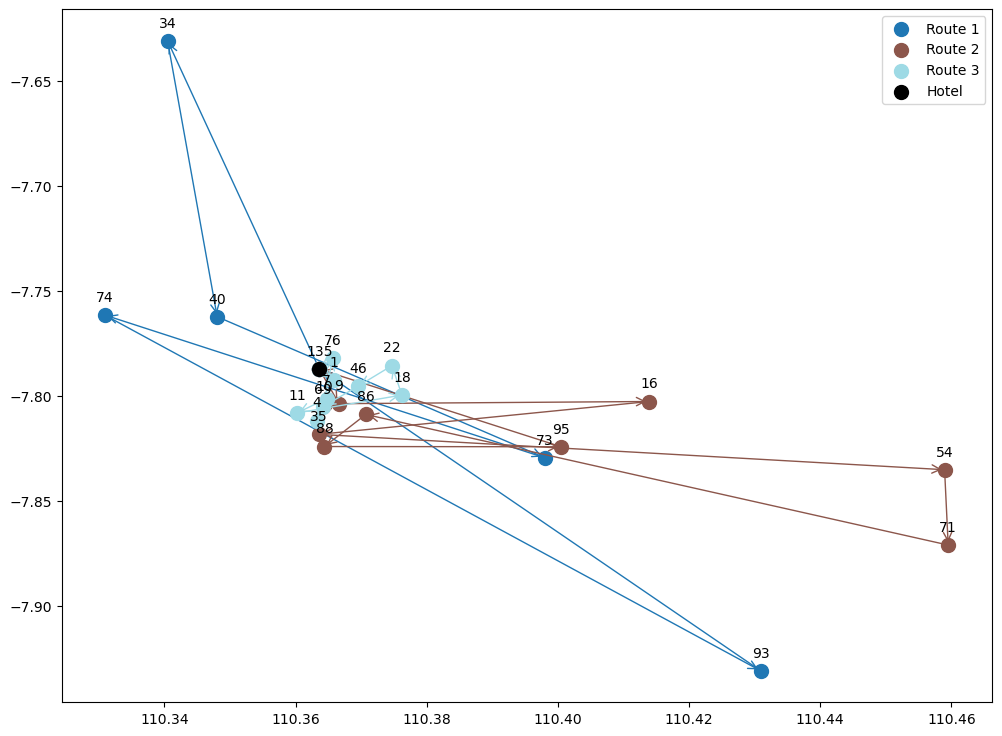

In [23]:
sol_node = get_detail_node_on_solution(results_acsbso_vrp['solution'])
visualize_solution(sol_node,hotel)

In [24]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[69, 76, 95, 18, 35, 9, 7, 86, 4, 73],
  [93, 11, 16, 88, 10, 74, 40],
  [51, 34, 1, 22, 46]],
 'fitness': 0.6851428406983961,
 'daily_fitness': [0.656007980115123, 0.6468223079830222, 0.6471035743357172],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.595454545454545,
 'total_tarif': 28000,
 'total_duration': 119760,
 'run_time': 6.3044114112854}

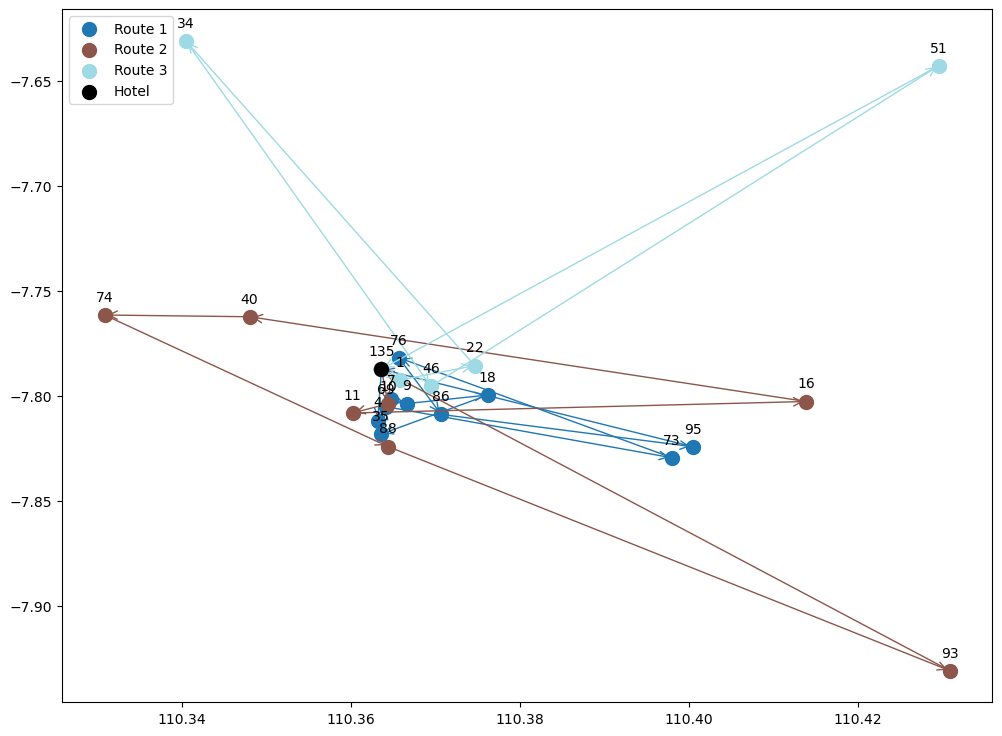

In [25]:
sol_node = get_detail_node_on_solution(results_haco_vrp['solution'])
visualize_solution(sol_node,hotel)

### 4. Running Time

In [26]:
n = [5,10,15,20,25,30]
run_time_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acs_vrp"].append(results_acs_vrp["run_time"])
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acs_tsp"].append(results_acs_tsp["run_time"])
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["bso_vrp"].append(results_bso_vrp["run_time"])
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["bso_tsp"].append(results_bso_tsp["run_time"])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acsbso_vrp"].append(results_acsbso_vrp["run_time"])
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acsbso_tsp"].append(results_acsbso_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [27]:
run_time_analysis

{'acs_vrp': [0.14901423454284668,
  0.7122282981872559,
  0.931408166885376,
  1.2380595207214355,
  2.4523963928222656,
  2.1012275218963623],
 'acs_tsp': [0.8212690353393555,
  1.4627857208251953,
  1.7876808643341064,
  2.9064199924468994,
  4.019197940826416,
  7.967195510864258],
 'bso_vrp': [0.021552085876464844,
  0.0872950553894043,
  0.032671213150024414,
  0.10877108573913574,
  0.3206052780151367,
  0.46221399307250977],
 'bso_tsp': [0.09041643142700195,
  0.6079244613647461,
  1.9754252433776855,
  4.755996465682983,
  9.51754117012024,
  16.696065187454224],
 'acsbso_vrp': [0.9007227420806885,
  3.019022226333618,
  5.118636608123779,
  6.393016815185547,
  24.106013774871826,
  36.01333022117615],
 'acsbso_tsp': [2.08699631690979,
  2.520441770553589,
  11.387165307998657,
  12.998181581497192,
  16.29230785369873,
  72.80968141555786]}

In [28]:
n = [5,10,15,20,25,30]
run_time_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["aco_vrp"].append(results_aco_vrp["run_time"])
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["aco_tsp"].append(results_aco_tsp["run_time"])
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["haco_vrp"].append(results_haco_vrp["run_time"])
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["haco_tsp"].append(results_haco_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [29]:
run_time_analysis

{'aco_vrp': [0.22355008125305176,
  0.7278487682342529,
  2.086726188659668,
  2.5886433124542236,
  2.030683994293213,
  2.8712899684906006],
 'aco_tsp': [0.28005456924438477,
  0.575416088104248,
  0.6913721561431885,
  2.074089288711548,
  2.1021053791046143,
  5.187346458435059],
 'haco_vrp': [0.6045598983764648,
  1.6661090850830078,
  3.7893054485321045,
  5.9059906005859375,
  5.344223499298096,
  6.818135976791382],
 'haco_tsp': [1.1374526023864746,
  1.7772738933563232,
  3.3268191814422607,
  5.374698638916016,
  7.399978399276733,
  9.450736999511719]}

### 5. Travel Duration

In [30]:
n = [5,10,15,20,25,30]
travel_duration_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_vrp"].append({key: results_acs_vrp[key] for key in keys})
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_tsp"].append({key: results_acs_tsp[key] for key in keys})
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_vrp"].append({key: results_bso_vrp[key] for key in keys})
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_tsp"].append({key: results_bso_tsp[key] for key in keys})
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_vrp"].append({key: results_acsbso_vrp[key] for key in keys})
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_tsp"].append({key: results_acsbso_tsp[key] for key in keys})

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [31]:
travel_duration_analysis

{'acs_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 62640, 'days_needed': 2},
  {'total_duration': 91440, 'days_needed': 3},
  {'total_duration': 122580, 'days_needed': 3},
  {'total_duration': 152580, 'days_needed': 4},
  {'total_duration': 180600, 'days_needed': 5}],
 'acs_tsp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 84120, 'days_needed': 3},
  {'total_duration': 105240, 'days_needed': 3},
  {'total_duration': 134520, 'days_needed': 4},
  {'total_duration': 173040, 'days_needed': 5},
  {'total_duration': 182460, 'days_needed': 5}],
 'bso_vrp': [{'total_duration': 24960, 'days_needed': 1},
  {'total_duration': 65940, 'days_needed': 2},
  {'total_duration': 92820, 'days_needed': 3},
  {'total_duration': 129240, 'days_needed': 4},
  {'total_duration': 185700, 'days_needed': 5},
  {'total_duration': 204240, 'days_needed': 6}],
 'bso_tsp': [{'total_duration': 25800, 'days_needed': 1},
  {'total_duration': 74760, 'days_needed': 2},
  {

In [32]:
n = [5,10,15,20,25,30]
travel_duration_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_vrp"].append({key: results_aco_vrp[key] for key in keys})
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_tsp"].append({key: results_aco_tsp[key] for key in keys})
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_vrp"].append({key: results_haco_vrp[key] for key in keys})
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_tsp"].append({key: results_haco_tsp[key] for key in keys})

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [33]:
travel_duration_analysis

{'aco_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 63480, 'days_needed': 2},
  {'total_duration': 93660, 'days_needed': 3},
  {'total_duration': 128940, 'days_needed': 3},
  {'total_duration': 157260, 'days_needed': 4},
  {'total_duration': 181920, 'days_needed': 5}],
 'aco_tsp': [{'total_duration': 24600, 'days_needed': 1},
  {'total_duration': 70200, 'days_needed': 2},
  {'total_duration': 98040, 'days_needed': 3},
  {'total_duration': 139380, 'days_needed': 4},
  {'total_duration': 175080, 'days_needed': 5},
  {'total_duration': 191100, 'days_needed': 5}],
 'haco_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 63120, 'days_needed': 2},
  {'total_duration': 91740, 'days_needed': 3},
  {'total_duration': 123000, 'days_needed': 3},
  {'total_duration': 154080, 'days_needed': 4},
  {'total_duration': 177300, 'days_needed': 5}],
 'haco_tsp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 84120, 'days_needed': 3},
  

### 6. Tarif

In [34]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,1,0

In [35]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[76, 18, 7, 22, 40, 74, 4, 10, 1],
  [88, 9, 46, 86, 39, 71, 35],
  [95, 16, 34, 11, 54, 73, 51]],
 'fitness': 0.8590986394557824,
 'daily_fitness': [0.65, 0.580952380952381, 0.6039115646258504],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.552173913043478,
 'total_tarif': 28500,
 'total_duration': 133680,
 'run_time': 2.8167765140533447}

In [36]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[76, 71, 18, 29, 53],
  [86, 54, 11, 34, 93],
  [39, 1, 46, 22, 4, 40, 73]],
 'fitness': 0.7202239229024943,
 'daily_fitness': [0.4812925170068027, 0.5790816326530612, 0.6064625850340136],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.535294117647059,
 'total_tarif': 68500,
 'total_duration': 122580,
 'run_time': 10.979671955108643}

In [37]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.6867339065255732,
 'daily_fitness': [0.395578231292517, 0.5945578231292517, 0.5574829931972789],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.21316909790039062}

In [38]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 22, 71, 18, 4, 73],
  [29, 16, 47, 86, 1, 88, 7],
  [76, 54, 34, 95, 64]],
 'fitness': 0.6503913139329807,
 'daily_fitness': [0.577891156462585, 0.395578231292517, 0.5408163265306123],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.51111111111111,
 'total_tarif': 168000,
 'total_duration': 119100,
 'run_time': 16.666497945785522}

In [39]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[54, 4, 76, 22, 93, 73, 10],
  [11, 16, 69, 88, 86, 1, 46, 35, 7, 9],
  [18, 34, 95, 74, 40, 71]],
 'fitness': 0.8616496598639456,
 'daily_fitness': [0.6124149659863946, 0.6360544217687075, 0.5914965986394558],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 133140,
 'run_time': 22.46999430656433}

In [40]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[71, 4, 16, 18, 9, 51],
  [11, 39, 10, 1, 22, 88, 53],
  [86, 69, 54, 7, 73, 64, 74]],
 'fitness': 0.7675878684807257,
 'daily_fitness': [0.5787414965986395, 0.5639455782312925, 0.5605442176870749],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.589999999999999,
 'total_tarif': 76500,
 'total_duration': 128880,
 'run_time': 202.1681354045868}

In [41]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[54, 22, 86, 46, 10, 7, 73, 1],
  [71, 4, 9, 40, 74, 93],
  [39, 16, 95, 76, 88, 35, 51]],
 'fitness': 0.8230221718316957,
 'daily_fitness': [0.6333333333333333, 0.5872448979591837, 0.5767006802721089],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.561904761904761,
 'total_tarif': 31000,
 'total_duration': 131160,
 'run_time': 4.337389230728149}

In [42]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[16, 76, 35, 39, 71, 88],
  [54, 1, 4, 72, 64],
  [11, 47, 74, 51, 29, 7]],
 'fitness': 0.5595852229780801,
 'daily_fitness': [0.5642857142857143, 0.413265306122449, 0.366156462585034],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.535294117647059,
 'total_tarif': 258500,
 'total_duration': 123960,
 'run_time': 6.285873889923096}

In [43]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[11, 10, 88, 93, 4, 35, 71],
  [76, 86, 74, 22, 95, 34, 51],
  [18, 16, 54, 73, 7, 9, 1, 46, 40]],
 'fitness': 0.8620748299319728,
 'daily_fitness': [0.5869047619047619, 0.6039115646258504, 0.65],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.552173913043478,
 'total_tarif': 25000,
 'total_duration': 133920,
 'run_time': 6.281080007553101}

In [44]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[95, 93, 46, 1, 22, 7, 10],
  [54, 73, 51, 86, 18, 4, 40],
  [29, 64, 53, 74, 35, 9]],
 'fitness': 0.7469875913328294,
 'daily_fitness': [0.6124149659863946, 0.6039115646258504, 0.4469387755102041],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.575,
 'total_tarif': 100000,
 'total_duration': 128100,
 'run_time': 9.740429162979126}

### 7. Rating

In [45]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,0,1

In [46]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[76, 73, 88, 64, 39, 71],
  [1, 46, 22, 40, 10, 35, 53, 7, 9],
  [74, 16, 69, 11, 18, 4, 86, 93]],
 'fitness': 0.8130992196209587,
 'daily_fitness': [0.4653846153846152, 0.5346153846153847, 0.4602564102564102],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.634782608695652,
 'total_tarif': 81500,
 'total_duration': 133860,
 'run_time': 4.169136047363281}

In [47]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[88, 7, 73, 69, 35, 74, 53, 46],
  [4, 9, 72, 93, 10, 95, 71],
  [51, 29, 34, 18, 86, 1]],
 'fitness': 0.7771825396825398,
 'daily_fitness': [0.5564102564102567, 0.4408424908424907, 0.407692307692308],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.628571428571429,
 'total_tarif': 163000,
 'total_duration': 130500,
 'run_time': 4.765065670013428}

In [48]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.7353602801519468,
 'daily_fitness': [0.4463369963369965, 0.4683150183150184, 0.3435897435897435],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.20700693130493164}

In [49]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 47, 16, 4, 29],
  [18, 71, 22, 86, 73, 1],
  [76, 54, 34, 95, 10, 46]],
 'fitness': 0.6762226970560303,
 'daily_fitness': [0.38333333333333347,
  0.4397435897435896,
  0.38205128205128214],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.5,
 'total_tarif': 143000,
 'total_duration': 112560,
 'run_time': 16.290318489074707}

In [50]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[76, 34, 7, 40, 4, 10, 88, 35, 9],
  [11, 69, 86, 95, 47, 16, 18, 53, 73],
  [72, 22, 46, 1, 74, 93]],
 'fitness': 0.8240622032288698,
 'daily_fitness': [0.4961538461538463,
  0.4790598290598289,
  0.48461538461538467],
 'days_needed': 3,
 'poi_included': 24,
 'avg_rating': 4.608333333333333,
 'total_tarif': 220500,
 'total_duration': 130800,
 'run_time': 28.331217288970947}

In [51]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[46, 76, 53, 1, 10, 93],
  [72, 47, 71, 4, 22, 7],
  [39, 69, 16, 54, 29, 40]],
 'fitness': 0.710116927825261,
 'daily_fitness': [0.5038461538461538,
  0.43333333333333357,
  0.3371794871794874],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.544444444444444,
 'total_tarif': 251500,
 'total_duration': 127320,
 'run_time': 177.48060178756714}

In [52]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[4, 10, 35, 22, 73, 88, 46, 53],
  [69, 64, 39, 93, 71],
  [74, 7, 9, 1, 18, 76, 51, 40]],
 'fitness': 0.7837958723375389,
 'daily_fitness': [0.5323717948717948,
  0.4294871794871793,
  0.48429487179487174],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.657142857142857,
 'total_tarif': 89000,
 'total_duration': 131100,
 'run_time': 2.718932628631592}

In [53]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[46, 53, 1, 7, 88, 9],
  [64, 74, 73, 93, 35],
  [69, 39, 51, 10, 22]],
 'fitness': 0.7024661680911681,
 'daily_fitness': [0.5423076923076925, 0.467948717948718, 0.4141025641025639],
 'days_needed': 3,
 'poi_included': 16,
 'avg_rating': 4.7125,
 'total_tarif': 84000,
 'total_duration': 115740,
 'run_time': 5.765897274017334}

In [54]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[69, 22, 4, 10, 88, 53, 9, 74],
  [40, 76, 18, 11, 7, 34, 1, 73, 35],
  [47, 16, 86, 46, 54, 95, 71]],
 'fitness': 0.8174679487179486,
 'daily_fitness': [0.5179487179487177, 0.491880341880342, 0.38589743589743597],
 'days_needed': 3,
 'poi_included': 24,
 'avg_rating': 4.570833333333333,
 'total_tarif': 148000,
 'total_duration': 132360,
 'run_time': 6.648310899734497}

In [55]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[46, 53, 1, 73, 88, 4],
  [34, 18, 54, 11, 93, 10],
  [7, 16, 22, 86, 29, 71]],
 'fitness': 0.7161918328584996,
 'daily_fitness': [0.5358974358974358,
  0.36923076923076903,
  0.4012820512820513],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.572222222222223,
 'total_tarif': 62500,
 'total_duration': 127200,
 'run_time': 9.852903127670288}

In [5]:
# setting
hotel,tur,timematrix = generate_data(n=10,random_state=30) #random state 50 blacklist
travel_days = 1
dwaktu,dtarif,drating = 1,1,1

In [8]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[74, 40, 7, 86, 4, 88, 93]],
 'fitness': 0.6427311665406904,
 'daily_fitness': [0.544652305366591],
 'days_needed': 1,
 'poi_included': 7,
 'avg_rating': 4.614285714285714,
 'total_tarif': 2500,
 'total_duration': 40320,
 'run_time': 3.095893383026123}

In [17]:
a= {1:[1,2,3],2:[3,2,1]}

In [18]:
len(a)

2